# Machine Learning Pipeline for Fatigue Prediction in the Biochemical Remission Cohort

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    auc,
    roc_curve,
    roc_auc_score,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import shap

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    GroupShuffleSplit,
    GroupKFold,
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pipeline Configuration

In [2]:
random_seed = 1337  # Random seed to ensure reproducibility
output_path = "output/biochem_remission/"
cmap = "berlin"  # Colormap for SHAP plots use "seismic" for full cohort and "berlin" for biochem remission cohort
file_prefix = "biochem_remission"

## Data Loading

In [3]:
df = pd.read_csv("working_data/all_ibd_ml_input.csv")
df = df[df["aggregate_disease_activity_Biochemical remission"] == 1] # Uncomment to run biochem remission pipeline

## Further Data Pre-Processing

In [4]:
# convert categorical columns to numerical
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fatigue_outcome"] = df["fatigue_outcome"].map({"fatigue": 1, "no_fatigue": 0})


In [5]:
# These columns are not features we want to use in the model
# Aggregate disease activity in some ways is a reflection of the other raw variables
columns_to_drop = [
    "aggregate_disease_activity_Active",
    "aggregate_disease_activity_Biochemical remission",
    "aggregate_disease_activity_Remission",
    "season_no_data",
    "study",
    "redcap_event_name_timepoint_1",
    "redcap_event_name_timepoint_2",
    "redcap_event_name_timepoint_3",
    "redcap_event_name_timepoint_4",
    "redcap_event_name_timepoint_5",
]

df.drop(columns=columns_to_drop, inplace=True)

In [6]:
# This column is dropped as all the values are 0.
columns_to_drop = [
    "baseline_eims_pyoderma_gangrenosum",
]

df.drop(columns=columns_to_drop, inplace=True)

In [7]:
numerical_features = [
    "age",
    "height",
    "weight",
    "bmi",
    "age_at_diagnosis",
    "albumin",
    "crp",
    "haemoglobin",
    "red_cell_count",
    "haematocrit",
    "white_cell_count",
    "neutrophils",
    "lymphocytes",
    "monocytes",
    "eosinophils",
    "basophils",
    "platelets",
    "urea",
    "creatinine",
    "sodium",
    "potassium",
    "calprotectin",
    "ada_drug_level",
    "ifx_drug_level",
    "diagnosis_year",
    "disease_duration_weeks",
]
scaler = StandardScaler()  # We have tried a variety of scaling methods and they did not affect final model output
scaler.fit(df[numerical_features])
df[numerical_features] = scaler.transform(df[numerical_features])

## Create Train and Test Datasets

GroupShuffleSplit used to ensure same participant only appears in either train or test set.

In [8]:
# GroupShuffleSplit
splitter = GroupShuffleSplit(test_size=0.3, n_splits=1, random_state=random_seed)

# Perform the split
for train_idx, test_idx in splitter.split(df, groups=df["study_id"]):
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

# Drop 'study_id' from X_train and X_test as it's not a feature
X_train = train_data.drop(columns=["fatigue_outcome", "study_id"])
y_train = train_data["fatigue_outcome"]

X_test = test_data.drop(columns=["fatigue_outcome", "study_id"])
y_test = test_data["fatigue_outcome"]

groups = train_data["study_id"]


## Hyperparameter Tuning

Find the best hyperparameters for each of the six models

In [9]:
# Models and parameter grids
models_and_params = {
    "Random Forest": (
        RandomForestClassifier(random_state=random_seed),
        {
            "n_estimators": [1000, 2000, 3000],
            "max_depth": [None, 5, 20],
            "min_samples_split": [2, 10, 20],
        },
    ),
    "Logistic Regression": (
        LogisticRegression(random_state=random_seed, max_iter=10000),
        {"C": [0.01, 1, 10], "penalty": ["l2"], "solver": ["lbfgs", "saga"]},
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=random_seed),
        {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1, 1]},
    ),
    "XGBoost": (
        xgb.XGBClassifier(random_state=random_seed, objective="binary:logistic"),
        {
            "n_estimators": [200, 400, 600],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 10],
        },
    ),
    "SVC": (
        SVC(probability=True, random_state=random_seed),
        {"C": [0.1, 1, 10], "gamma": [0.001, 0.01, 1]},
    ),
    "MLPClassifier": (
        MLPClassifier(max_iter=10000, random_state=random_seed),
        {
            "hidden_layer_sizes": [(100, 50), (100,), (90,), (110,)],
            "activation": ["tanh", "relu"],
            "solver": ["sgd", "adam"],
        },
    ),
}

# GroupKFold cross-validation method with 5 splits
cv = GroupKFold(n_splits=5)

# Results storage
results = {}

for model_name, (model, param_grid) in models_and_params.items():
    print(f"Running GridSearch for {model_name}...")
    grid = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="roc_auc"
    )
    grid.fit(
        X_train, y_train, groups=groups
    )  # Pass groups to ensure grouping of study_id into either train or validate sets

    # Extract best parameters, mean, and standard deviation of test scores
    results[model_name] = {
        "best_params": grid.best_params_,
        "mean_score": grid.cv_results_["mean_test_score"][grid.best_index_],
        "std_score": grid.cv_results_["std_test_score"][grid.best_index_],
        "grid": grid,  # Save the grid object for future use
    }

# Display Results
results_df = pd.DataFrame(results).T
print(results_df)

Running GridSearch for Random Forest...
Running GridSearch for Logistic Regression...
Running GridSearch for AdaBoost...


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/si

Running GridSearch for XGBoost...
Running GridSearch for SVC...
Running GridSearch for MLPClassifier...
                                                           best_params  \
Random Forest        {'max_depth': 5, 'min_samples_split': 20, 'n_e...   
Logistic Regression       {'C': 10, 'penalty': 'l2', 'solver': 'saga'}   
AdaBoost                   {'learning_rate': 0.01, 'n_estimators': 50}   
XGBoost              {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   
SVC                                         {'C': 0.1, 'gamma': 0.001}   
MLPClassifier        {'activation': 'tanh', 'hidden_layer_sizes': (...   

                    mean_score std_score  \
Random Forest         0.617927   0.11155   
Logistic Regression   0.674551  0.106003   
AdaBoost              0.723919  0.131774   
XGBoost               0.652693  0.138537   
SVC                   0.607425  0.033842   
MLPClassifier         0.658262  0.122572   

                                                                  gr

Hyperparameter Results:

Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 1000}

Log reg: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

Adaboost: {'learning_rate': 0.1, 'n_estimators': 50}

XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}

SVC: {'C': 10, 'gamma': 0.001}

MLPClassifier: {'activation': 'relu', 'hidden_layer_sizes': (110,), 'solver': 'adam'}

## Final Model Training and Evaluation

Evaluating Random Forest...
Evaluating Logistic Regression...
Evaluating AdaBoost...
Evaluating XGBoost...


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/si

Evaluating SVC...
Evaluating MLPClassifier...


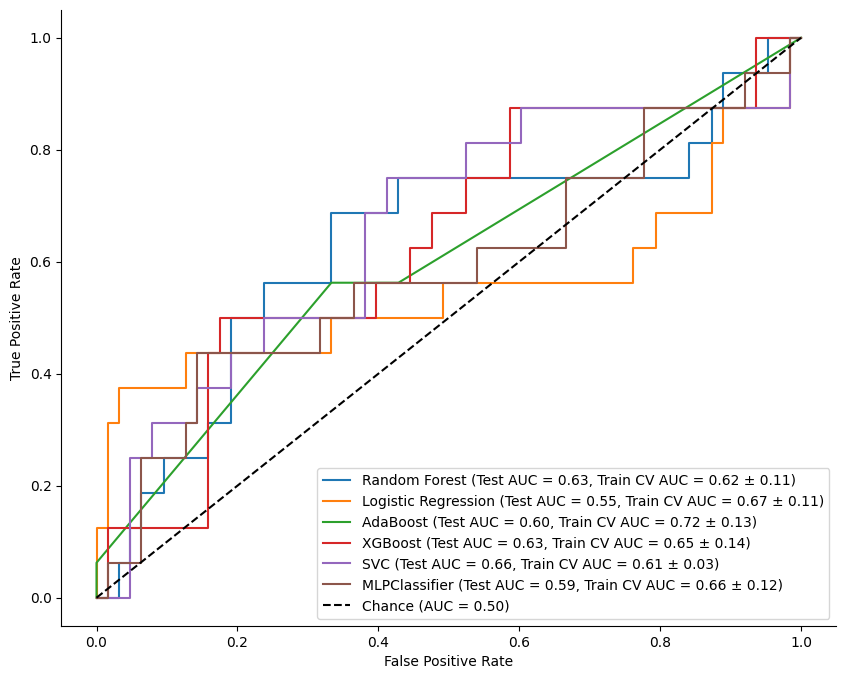

In [10]:
# Dictionary to store fitted models and their AUC scores, including mean and SD
fitted_models = {}
roc_results = {}

# Loop through the models and evaluate mean and SD of AUC
for model_name, (model, _) in models_and_params.items():
    print(f"Evaluating {model_name}...")

    # Get best parameters from grid search
    best_params = results[model_name]["best_params"]

    # Initialize the model with best parameters
    best_model = model.set_params(**best_params)

    # Perform cross-validation with GroupKFold
    cv_auc_scores = cross_val_score(
        best_model, X_train, y_train, cv=cv, groups=groups, scoring="roc_auc", n_jobs=-1
    )

    # Compute mean and SD of AUC
    mean_auc = np.mean(cv_auc_scores)
    std_auc = np.std(cv_auc_scores)

    # Fit the model to the entire training set
    best_model.fit(X_train, y_train)

    # Store the fitted model
    fitted_models[model_name] = best_model

    # Predict probabilities for the test set
    y_test_proba = best_model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC on the test set
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    test_auc = auc(fpr, tpr)

    # Store the results for plotting
    roc_results[model_name] = {
        "fpr": fpr,
        "tpr": tpr,
        "test_auc": test_auc,
        "mean_auc": mean_auc,
        "std_auc": std_auc,
    }

# Plot ROC curves for all models with mean and SD of AUC
plt.figure(figsize=(10, 8))

for model_name, roc_data in roc_results.items():
    mean_auc = roc_data["mean_auc"]
    std_auc = roc_data["std_auc"]
    test_auc = roc_data["test_auc"]
    plt.plot(
        roc_data["fpr"],
        roc_data["tpr"],
        label=f"{model_name} (Test AUC = {test_auc:.2f}, Train CV AUC = {mean_auc:.2f} ± {std_auc:.2f})",
    )

# Add baseline and plot details
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend(loc="lower right")

# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Define the absolute path
save_path = f"{output_path}{file_prefix}_roc_curves.png"

# Save the plot to the specified path
plt.savefig(save_path, dpi=300)

# Display the plot
plt.show()

### Model Metrics Stored in CSV Table

In [11]:
# Dictionary to store metrics for each model
metrics_results = []

for model_name, best_model in fitted_models.items():
    print(f"Evaluating metrics for {model_name}...")

    # Predict on the test set
    y_test_pred = best_model.predict(X_test)
    y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for AUC

    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    sensitivity = recall_score(y_test, y_test_pred)  # TPR
    specificity = tn / (tn + fp)  # TNR
    auc_score = roc_auc_score(y_test, y_test_proba)

    # Store results
    metrics_results.append(
        {
            "Model": model_name,
            "Accuracy": round(accuracy, 3),
            "Sensitivity (Recall)": round(sensitivity, 3),
            "Specificity": round(specificity, 3),
            "AUC": round(auc_score, 3),
        }
    )

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_results)

# Sort the DataFrame by the "AUC" column in descending order
metrics_df = metrics_df.sort_values(by="AUC", ascending=False)

# Save to CSV
output_file = f"{output_path}{file_prefix}_model_metrics.csv"
metrics_df.to_csv(output_file, index=False)

print(f"Metrics saved to {output_file}")

Evaluating metrics for Random Forest...
Evaluating metrics for Logistic Regression...
Evaluating metrics for AdaBoost...
Evaluating metrics for XGBoost...
Evaluating metrics for SVC...
Evaluating metrics for MLPClassifier...
Metrics saved to output/biochem_remission/biochem_remission_model_metrics.csv


## SHAP Plots for Each Model

### Random Forest

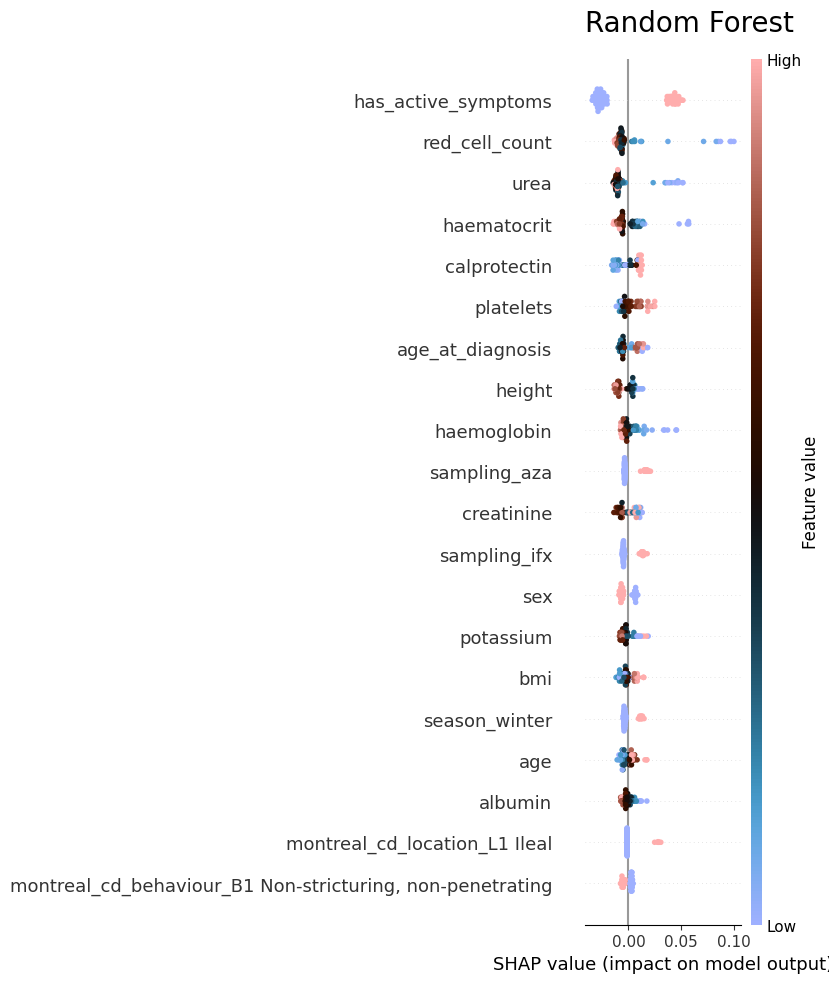

In [12]:
# Retrieve the GridSearchCV object for Random Forest
rf_grid = results["Random Forest"]["grid"]

# Retrieve the best Random Forest model
rf_best_model = rf_grid.best_estimator_

# SHAP Analysis
explainer = shap.TreeExplainer(rf_best_model)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values
shap_values_class_1 = shap_values[:, :, 1]

# Correct feature names as a list
feature_names = X_test.columns.tolist()

# Plot SHAP summary plot with correct feature names
shap.summary_plot(
    shap_values_class_1, X_test, feature_names=feature_names, show=False, cmap=cmap
)

plt.title("Random Forest", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_random_forest.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()


### Logistic Regression

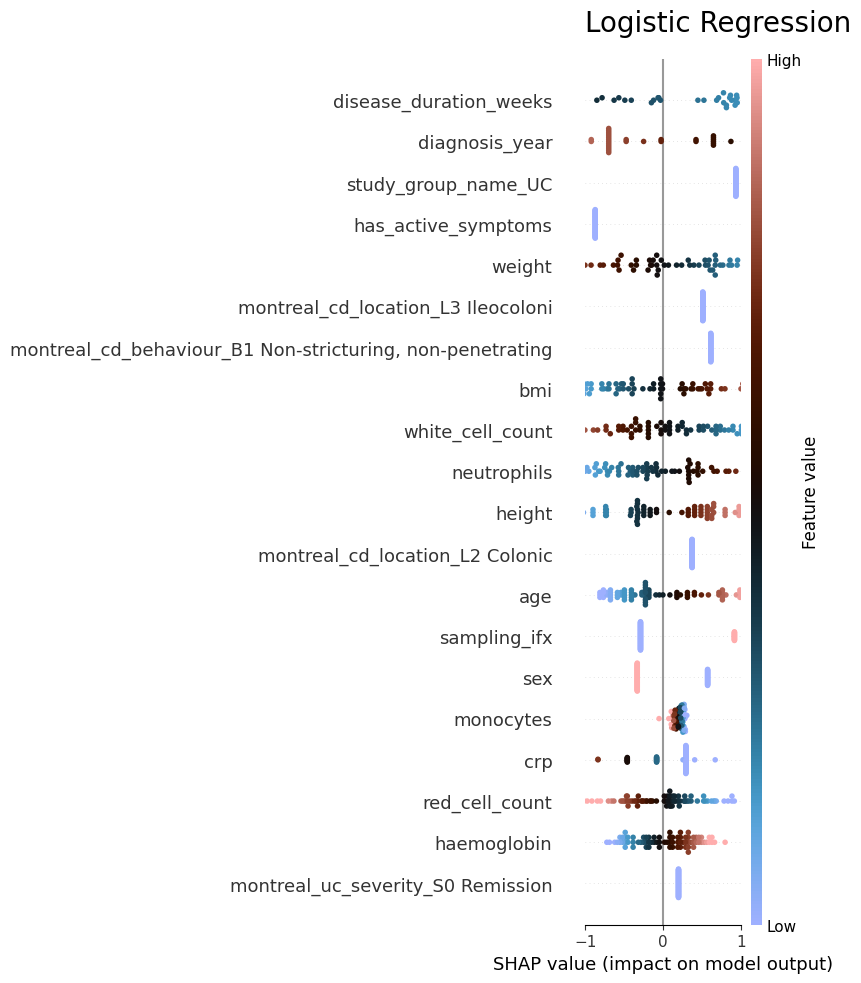

In [13]:
# Retrieve the GridSearchCV object for Logistic Regression
logreg_grid = results["Logistic Regression"]["grid"]

# Retrieve the best Logistic Regression model
logreg_best_model = logreg_grid.best_estimator_

# SHAP plot for logistic regression on test set
masker = shap.maskers.Independent(data=X_test)
explainer = shap.LinearExplainer(logreg_best_model, masker=masker)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values, X_test, feature_names=X_test.columns, show=False, cmap=cmap
)

plt.title("Logistic Regression", fontsize=20, pad=20, loc="left")
plt.xlim(-1, 1)

save_path = f"{output_path}shap_logistic_regression.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### AdaBoost

In [14]:
# Retrieve the GridSearchCV object for AdaBoost
adaboost_grid = results["AdaBoost"]["grid"]

# Retrieve the best Logistic Regression model
adaboost_best_model = adaboost_grid.best_estimator_

X_test_sample = shap.sample(X_test, 50)
explainer = shap.KernelExplainer(adaboost_best_model.predict_proba, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)


100%|██████████| 50/50 [00:25<00:00,  1.92it/s]


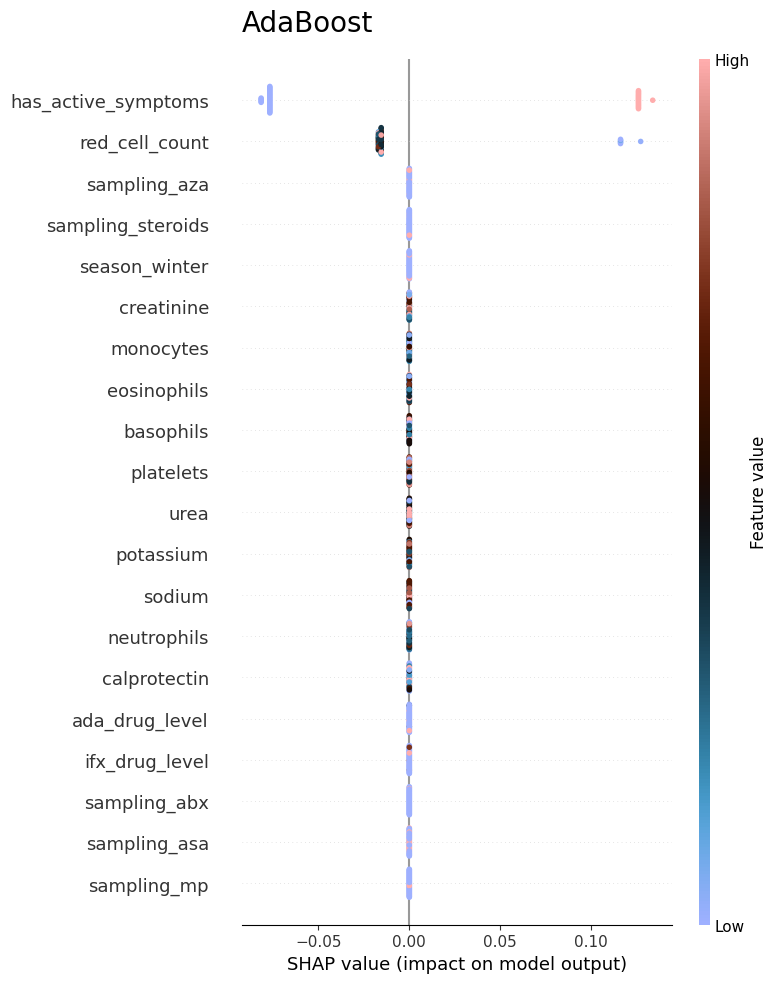

In [15]:
shap_values_class_1 = shap_values[:, :, 1]
shap.summary_plot(
    shap_values_class_1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    show=False,
    cmap=cmap,
)

plt.title("AdaBoost", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_adaboost.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### XGBoost

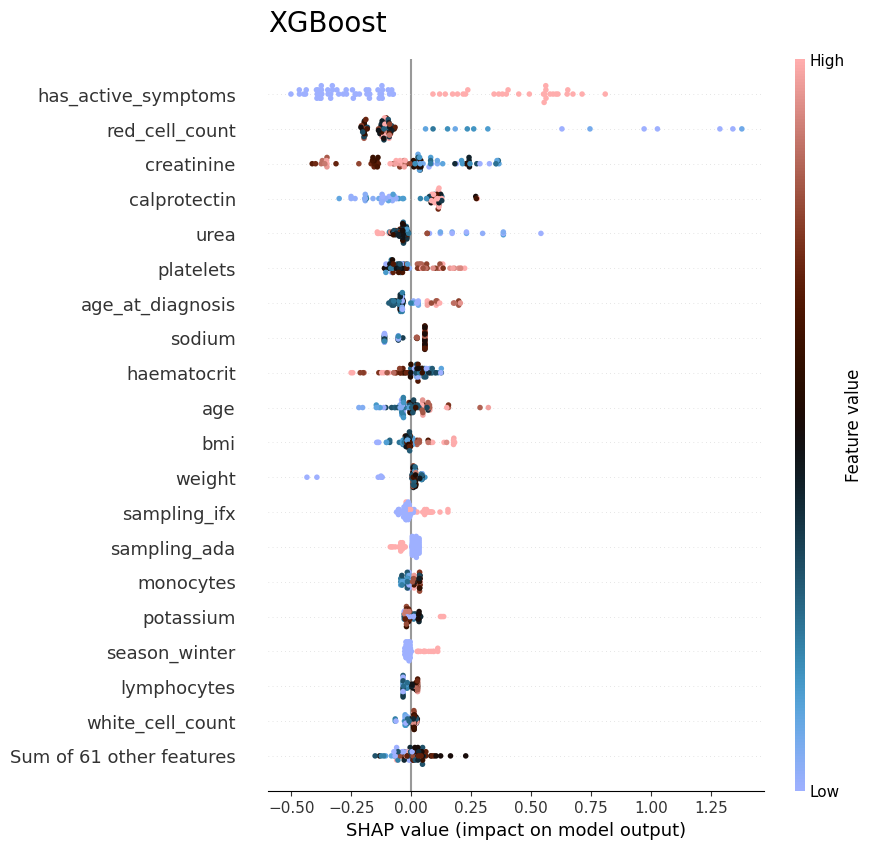

In [16]:
# Retrieve the GridSearchCV object for AdaBoost
xgboost_grid = results["XGBoost"]["grid"]

# Retrieve the best Logistic Regression model
xgboost_best_model = xgboost_grid.best_estimator_

explainer = shap.Explainer(xgboost_best_model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, max_display=20, show=False, color=plt.get_cmap(cmap))
plt.title("XGBoost", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_xgboost.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### MLPClassifier

In [17]:
# Retrieve the GridSearchCV object for MLPClassifier
mlp_grid = results["MLPClassifier"]["grid"]

mlp_best_model = mlp_grid.best_estimator_

X_test_sample = shap.sample(X_test, 50)
explainer = shap.KernelExplainer(mlp_best_model.predict_proba, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)


100%|██████████| 50/50 [00:10<00:00,  4.77it/s]


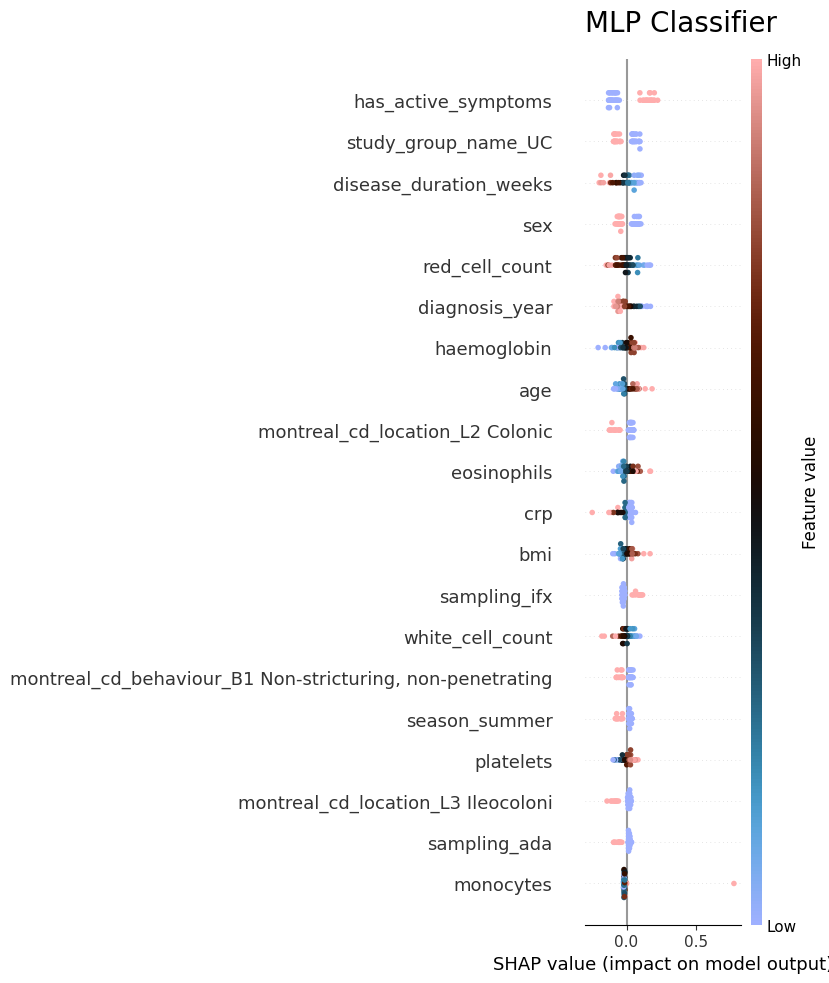

In [18]:
shap_values_class_1 = shap_values[:, :, 1]
shap.summary_plot(
    shap_values_class_1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    show=False,
    cmap=cmap,
)

plt.title("MLP Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_mlp.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

### SVC

In [19]:
# Retrieve the GridSearchCV object for MLPClassifier
svc_grid = results["SVC"]["grid"]

svc_best_model = svc_grid.best_estimator_

X_test_sample = shap.sample(X_test, 40)
explainer = shap.KernelExplainer(svc_best_model.predict_proba, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)


100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


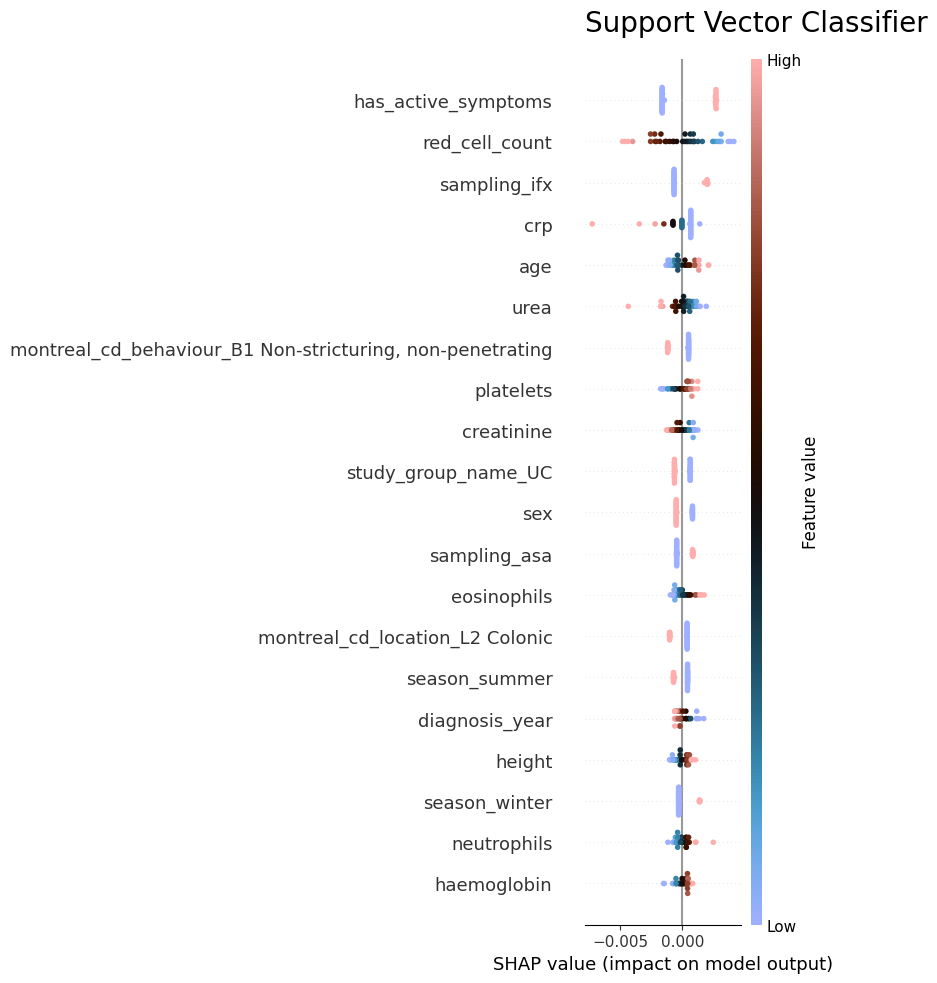

In [20]:
shap_values_class_1 = shap_values[:, :, 1]
shap.summary_plot(
    shap_values_class_1,
    X_test_sample,
    feature_names=X_test_sample.columns,
    show=False,
    max_display=20,
    cmap=cmap,
)

plt.title("Support Vector Classifier", fontsize=20, pad=20, loc="left")

save_path = f"{output_path}shap_svc.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()